In [ ]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as pyplot
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from matplotlib import pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [ ]:
class ECGDataSet(torch.utils.data.Dataset):
  def __init__(self, ecg_address="/content/drive/MyDrive/Intelliscope/Software/ML/Classification 12/ECG_data.npy",
               demographic_address="/content/drive/MyDrive/Intelliscope/Software/ML/Classification 12/Demographic_data.npy",
               Y_address="/content/drive/MyDrive/Intelliscope/Software/ML/Classification 12/Y.npy"):
    self.X_ECG = np.load(ecg_address).astype(np.float32)
    self.X_demographic = np.load(demographic_address)
    values = np.load(Y_address)
    n_values = np.max(values) + 1
    self.Y = np.eye(n_values)[values]

    if self.X_demographic.shape[0] == self.X_ECG.shape[0] == self.Y.shape[0]: print("[INFO] Data loaded successfully. {} test cases.".format(self.Y.shape[0]))
    else: print("[ERROR] Data loading incomplete.")

  def __len__(self):
    return self.Y.shape[0]

  def __getitem__(self, index):
    return [self.X_ECG[index], self.X_demographic[index]], self.Y[index]


In [ ]:
class SEModule(nn.Module):
    def __init__(self,
        in_channels,
        reduction = 16,
    ):
        super(SEModule, self).__init__()
        self.pool = nn.AdaptiveAvgPool1d(1)

        self.s_conv = nn.Conv1d(
            in_channels, in_channels//reduction,
            kernel_size = 1,
        )
        self.act_fn = nn.ReLU()
        self.e_conv = nn.Conv1d(
            in_channels//reduction, in_channels,
            kernel_size = 1,
        )

    def forward(self,
        input,
    ):
        attention_scores = self.pool(input)
        attention_scores = self.s_conv(attention_scores)
        attention_scores = self.act_fn(attention_scores)
        attention_scores = self.e_conv(attention_scores)
        return input*torch.sigmoid(attention_scores)

class SEResBlock(nn.Module):
    def __init__(self,
        in_channels,
        downsample = False,
    ):
        super(SEResBlock, self).__init__()
        if downsample:
            self.out_channels = in_channels*2
            self.conv_1 = nn.Conv1d(
                in_channels, self.out_channels,
                kernel_size = 7, padding = 3, stride = 2,
            )
            self.identity = nn.Sequential(
                nn.Conv1d(
                    in_channels, self.out_channels,
                    kernel_size = 1, padding = 0, stride = 2,
                ),
                nn.BatchNorm1d(self.out_channels),
            )
        else:
            self.out_channels = in_channels
            self.conv_1 = nn.Conv1d(
                in_channels, self.out_channels,
                kernel_size = 7, padding = 3, stride = 1,
            )
            self.identity = nn.Identity()
        self.conv_2 = nn.Conv1d(
            self.out_channels, self.out_channels,
            kernel_size = 7, padding = 3, stride = 1,
        )

        self.convs = nn.Sequential(
            self.conv_1,
            nn.BatchNorm1d(self.out_channels),
            nn.ReLU(),
            nn.Dropout(0.3),
            self.conv_2,
            nn.BatchNorm1d(self.out_channels),
            SEModule(self.out_channels),
        )
        self.act_fn = nn.ReLU()

    def forward(self,
        input,
    ):
        output = self.convs(input) + self.identity(input)
        output = self.act_fn(output)

        return output

class SEResNet18(nn.Module):
    def __init__(self,
        base_channels = 64,
    ):
        super(SEResNet18, self).__init__()
        self.bblock = SEResBlock
        self.stem = nn.Sequential(
            nn.Conv1d(
                1, base_channels,
                kernel_size = 15, padding = 7, stride = 2,
            ),
            nn.BatchNorm1d(base_channels),
            nn.ReLU(),
            nn.MaxPool1d(
                kernel_size = 3, padding = 1, stride = 2,
            ),
        )
        self.stage_0 = nn.Sequential(
            self.bblock(base_channels),
            self.bblock(base_channels),
        )

        self.stage_1 = nn.Sequential(
            self.bblock(base_channels*1, downsample = True),
            self.bblock(base_channels*2),
        )
        self.stage_2 = nn.Sequential(
            self.bblock(base_channels*2, downsample = True),
            self.bblock(base_channels*4),
        )
        self.stage_3 = nn.Sequential(
            self.bblock(base_channels*4, downsample = True),
            self.bblock(base_channels*8),
        )

        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self,
        input,
    ):
        output = self.stem(input)
        output = self.stage_0(output)

        output = self.stage_1(output)
        output = self.stage_2(output)
        output = self.stage_3(output)

        output = self.pool(output)

        return output

In [ ]:
class X3ECGpp(nn.Module):
    def __init__(self,
        base_channels = 64,
        num_classes = 12,
    ):
        super(X3ECGpp, self).__init__()
        self.backbone_0 = SEResNet18(base_channels)
        self.backbone_1 = SEResNet18(base_channels)
        self.backbone_2 = SEResNet18(base_channels)

        self.lw_attention = nn.Sequential(
            nn.Linear(
                base_channels*16, base_channels*8,
            ),
            nn.BatchNorm1d(base_channels*8),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(
                base_channels*8, 2,
                      ),
        )
 Sinus Rhythm

        self.regressor = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(
                base_channels*8, 1,
            ),
        )

        self.backbone_demogr = nn.Sequential(
            nn.Linear(
                2, base_channels*2,
            ),
            nn.BatchNorm1d(base_channels*2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(
                base_channels*2, base_channels*2,
            ),
            nn.BatchNorm1d(base_channels*2),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(
                base_channels*10, num_classes,
            ),
            nn.Softmax(dim=1),
        )

    def forward(self,
        ecg_input,
        demo_input,
        return_attention_scores = False,
    ):
        demo_input = demo_input.float()
        features_0 = self.backbone_0(ecg_input[:, 0, :].unsqueeze(1)).squeeze(2)
        features_1 = self.backbone_1(ecg_input[:, 1, :].unsqueeze(1)).squeeze(2)
        # features_2 = self.backbone_2(ecg_input[:, 2, :].unsqueeze(1)).squeeze(2)
        attention_scores = torch.sigmoid(
            self.lw_attention(
                torch.cat(
                [
                    features_0,
                    features_1,
                    # features_2,
                ],
                dim = 1,
                )
            )
        )
        merged_features = torch.sum(
            torch.stack(
            [
                features_0,
                features_1,
                # features_2,
            ],
            dim = 1,
            )*attention_scores.unsqueeze(-1),
            dim = 1,
        )
        # sub_output = self.regressor(merged_features).squeeze(-1)
        merged_features = torch.cat(
            [
                merged_features,
                self.backbone_demogr(demo_input),
            ],
            axis = 1,
        )
        output = self.classifier(merged_features)

        # if not return_attention_scores:
        #     return (output, sub_output)
        # else:
        #     return (output, sub_output), attention_scores

        if not return_attention_scores:
            return output
        else:
            return output, attention_scores

In [ ]:
def Softmax_2_Onehot(probs):
  max_idx = torch.argmax(probs, dim=1, keepdim=True)
  one_hot = torch.FloatTensor(probs.shape)
  one_hot.zero_()
  one_hot.scatter_(1, max_idx, 1)
  return one_hot.numpy()

In [ ]:
def train_model(model, train_dl, validation_dl, epoches, learning_rate, T_max=40, eta_min=7.5e-6):
    criterian = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-5)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min, verbose=True)
    train_loss_schedule, validation_loss_schedule = [], []

    for epoch in range(epoches):
        for i, (X, Y) in tqdm(enumerate(train_dl)):
            optimizer.zero_grad()
            Y_pred = model(torch.as_tensor(X[0]).to(device), torch.as_tensor(X[1]).to(device))
            train_loss = criterian(Y_pred.reshape((Y_pred.shape[0], 12)), Y.float().to(device))
            train_loss.backward()
            optimizer.step()
        if epoch < T_max: lr_scheduler.step()

        for i, (X, Y) in enumerate(validation_dl):
            Y_pred = model(torch.as_tensor(X[0]).to(device), torch.as_tensor(X[1]).to(device))
            validation_loss = criterian(Y_pred.reshape((Y_pred.shape[0], 12)), Y.float().to(device))

        train_loss_schedule.append(float(train_loss.to("cpu")))
        validation_loss_schedule.append(float(validation_loss.to("cpu")))
        print("[INFO] Completed epoch {}/{} ---> Train loss = {} | Validation loss = {}".format(epoch+1, epoches, round(float(train_loss.to("cpu")), 5), round(float(validation_loss.to("cpu")), 5)))

    plt.plot(range(epoches), np.array(train_loss_schedule)), plt.plot(range(epoches), np.array(validation_loss_schedule))
    plt.xlabel("Epoch"), plt.ylabel("Loss"), plt.title("Epoch vs Loss"), plt.legend(['Train loss', 'Validation loss'])
    plt.show()
    return

def evaluate_model(model, dl, dl_name):
    predictions, actuals = [], []

    for i, (X, Y) in enumerate(dl):
        Y_pred = model(torch.as_tensor(X[0]).to(device), torch.as_tensor(X[1]).to(device))
        Y_pred = Softmax_2_Onehot(Y_pred.detach().to("cpu"))
        Y = Y.numpy()
        Y = Y.reshape((len(Y), 12))
        predictions.append(Y_pred)
        actuals.append(Y)

    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    acc = accuracy_score(actuals, predictions)
    f1 = f1_score(actuals, predictions, average="weighted", zero_division=0)
    print("[INFO] {} accuracy = {} | f1-score = {}".format(dl_name, round(acc, 5), round(f1, 5)))

    if dl_name == "Test":
      cm = confusion_matrix(actuals.argmax(axis=1), predictions.argmax(axis=1), labels=range(12))
      lables = ["SB", "SR", "AFIB", "ST", "SA", "AF", "SI", "SVT", "AT", "AVNRT", "AVRT", "SAAWR"]
      ax= plt.subplot()
      sns.heatmap(cm, annot=True, fmt='g', ax=ax);
      ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
      ax.set_title('Confusion Matrix');
      ax.xaxis.set_ticklabels(lables, rotation=45); ax.yaxis.set_ticklabels(lables, rotation=45);
      plt.show()
    return


In [ ]:
dataset = ECGDataSet()

train, validation, test = torch.utils.data.random_split(dataset, [9600, 600, 445])
train_dl = torch.utils.data.DataLoader(train, batch_size=150, shuffle=True)
validation_dl = torch.utils.data.DataLoader(validation, batch_size=150, shuffle=True)
test_dl = torch.utils.data.DataLoader(test, batch_size=89, shuffle=False)

[INFO] Data loaded successfully. 10645 test cases.


Adjusting learning rate of group 0 to 7.5000e-05.


64it [01:10,  1.10s/it]


Adjusting learning rate of group 0 to 7.4896e-05.
[INFO] Completed epoch 1/100 ---> Train loss = 1.86398 | Validation loss = 1.88009


64it [01:07,  1.05s/it]


Adjusting learning rate of group 0 to 7.4584e-05.
[INFO] Completed epoch 2/100 ---> Train loss = 1.79795 | Validation loss = 1.77752


64it [01:06,  1.04s/it]


Adjusting learning rate of group 0 to 7.4067e-05.
[INFO] Completed epoch 3/100 ---> Train loss = 1.79345 | Validation loss = 1.77062


64it [01:06,  1.05s/it]


Adjusting learning rate of group 0 to 7.3348e-05.
[INFO] Completed epoch 4/100 ---> Train loss = 1.75124 | Validation loss = 1.76323


64it [01:06,  1.05s/it]


Adjusting learning rate of group 0 to 7.2431e-05.
[INFO] Completed epoch 5/100 ---> Train loss = 1.74899 | Validation loss = 1.76225


64it [01:06,  1.05s/it]


Adjusting learning rate of group 0 to 7.1321e-05.
[INFO] Completed epoch 6/100 ---> Train loss = 1.72455 | Validation loss = 1.72682


64it [01:06,  1.05s/it]


Adjusting learning rate of group 0 to 7.0027e-05.
[INFO] Completed epoch 7/100 ---> Train loss = 1.72252 | Validation loss = 1.77201


64it [01:06,  1.05s/it]


Adjusting learning rate of group 0 to 6.8554e-05.
[INFO] Completed epoch 8/100 ---> Train loss = 1.75439 | Validation loss = 1.73375


64it [01:06,  1.05s/it]


Adjusting learning rate of group 0 to 6.6914e-05.
[INFO] Completed epoch 9/100 ---> Train loss = 1.75977 | Validation loss = 1.70161


64it [01:07,  1.05s/it]


Adjusting learning rate of group 0 to 6.5115e-05.
[INFO] Completed epoch 10/100 ---> Train loss = 1.71859 | Validation loss = 1.71152


64it [01:07,  1.05s/it]


Adjusting learning rate of group 0 to 6.3169e-05.
[INFO] Completed epoch 11/100 ---> Train loss = 1.73216 | Validation loss = 1.74953


64it [01:07,  1.05s/it]


Adjusting learning rate of group 0 to 6.1088e-05.
[INFO] Completed epoch 12/100 ---> Train loss = 1.75169 | Validation loss = 1.70974


64it [01:07,  1.05s/it]


Adjusting learning rate of group 0 to 5.8884e-05.
[INFO] Completed epoch 13/100 ---> Train loss = 1.75264 | Validation loss = 1.74287


64it [01:07,  1.05s/it]


Adjusting learning rate of group 0 to 5.6572e-05.
[INFO] Completed epoch 14/100 ---> Train loss = 1.71577 | Validation loss = 1.70887


64it [01:07,  1.05s/it]


Adjusting learning rate of group 0 to 5.4166e-05.
[INFO] Completed epoch 15/100 ---> Train loss = 1.69542 | Validation loss = 1.73262


64it [01:07,  1.05s/it]


Adjusting learning rate of group 0 to 5.1679e-05.
[INFO] Completed epoch 16/100 ---> Train loss = 1.68873 | Validation loss = 1.75565


64it [01:07,  1.05s/it]


Adjusting learning rate of group 0 to 4.9129e-05.
[INFO] Completed epoch 17/100 ---> Train loss = 1.69704 | Validation loss = 1.70833


64it [01:07,  1.05s/it]


Adjusting learning rate of group 0 to 4.6530e-05.
[INFO] Completed epoch 18/100 ---> Train loss = 1.71709 | Validation loss = 1.73801


64it [01:06,  1.05s/it]


Adjusting learning rate of group 0 to 4.3898e-05.
[INFO] Completed epoch 19/100 ---> Train loss = 1.72524 | Validation loss = 1.74871


64it [01:07,  1.05s/it]


Adjusting learning rate of group 0 to 4.1250e-05.
[INFO] Completed epoch 20/100 ---> Train loss = 1.71063 | Validation loss = 1.7606


64it [01:06,  1.04s/it]


Adjusting learning rate of group 0 to 3.8602e-05.
[INFO] Completed epoch 21/100 ---> Train loss = 1.72779 | Validation loss = 1.75864


64it [01:07,  1.05s/it]


Adjusting learning rate of group 0 to 3.5970e-05.
[INFO] Completed epoch 22/100 ---> Train loss = 1.73047 | Validation loss = 1.71502


64it [01:06,  1.05s/it]


Adjusting learning rate of group 0 to 3.3371e-05.
[INFO] Completed epoch 23/100 ---> Train loss = 1.74931 | Validation loss = 1.75461


64it [01:07,  1.05s/it]


Adjusting learning rate of group 0 to 3.0821e-05.
[INFO] Completed epoch 24/100 ---> Train loss = 1.70619 | Validation loss = 1.73605


64it [01:06,  1.05s/it]


Adjusting learning rate of group 0 to 2.8334e-05.
[INFO] Completed epoch 25/100 ---> Train loss = 1.72315 | Validation loss = 1.73156


64it [01:06,  1.04s/it]


Adjusting learning rate of group 0 to 2.5928e-05.
[INFO] Completed epoch 26/100 ---> Train loss = 1.70995 | Validation loss = 1.73624


64it [01:06,  1.04s/it]


Adjusting learning rate of group 0 to 2.3616e-05.
[INFO] Completed epoch 27/100 ---> Train loss = 1.711 | Validation loss = 1.72103


64it [01:06,  1.04s/it]


Adjusting learning rate of group 0 to 2.1412e-05.
[INFO] Completed epoch 28/100 ---> Train loss = 1.7232 | Validation loss = 1.72187


64it [01:06,  1.05s/it]


Adjusting learning rate of group 0 to 1.9331e-05.
[INFO] Completed epoch 29/100 ---> Train loss = 1.70076 | Validation loss = 1.74462


64it [01:06,  1.05s/it]


Adjusting learning rate of group 0 to 1.7385e-05.
[INFO] Completed epoch 30/100 ---> Train loss = 1.66221 | Validation loss = 1.67607


64it [01:06,  1.05s/it]


Adjusting learning rate of group 0 to 1.5586e-05.
[INFO] Completed epoch 31/100 ---> Train loss = 1.67408 | Validation loss = 1.72291


64it [01:06,  1.05s/it]


Adjusting learning rate of group 0 to 1.3946e-05.
[INFO] Completed epoch 32/100 ---> Train loss = 1.74457 | Validation loss = 1.6838


64it [01:06,  1.05s/it]


Adjusting learning rate of group 0 to 1.2473e-05.
[INFO] Completed epoch 33/100 ---> Train loss = 1.69413 | Validation loss = 1.74726


64it [01:06,  1.05s/it]


Adjusting learning rate of group 0 to 1.1179e-05.
[INFO] Completed epoch 34/100 ---> Train loss = 1.69207 | Validation loss = 1.76039


64it [01:06,  1.05s/it]


Adjusting learning rate of group 0 to 1.0069e-05.
[INFO] Completed epoch 35/100 ---> Train loss = 1.70668 | Validation loss = 1.74302


64it [01:06,  1.05s/it]


Adjusting learning rate of group 0 to 9.1518e-06.
[INFO] Completed epoch 36/100 ---> Train loss = 1.71474 | Validation loss = 1.70782


64it [01:06,  1.05s/it]


Adjusting learning rate of group 0 to 8.4325e-06.
[INFO] Completed epoch 37/100 ---> Train loss = 1.75327 | Validation loss = 1.68849


64it [01:06,  1.05s/it]


Adjusting learning rate of group 0 to 7.9155e-06.
[INFO] Completed epoch 38/100 ---> Train loss = 1.6934 | Validation loss = 1.76312


64it [01:06,  1.05s/it]


Adjusting learning rate of group 0 to 7.6040e-06.
[INFO] Completed epoch 39/100 ---> Train loss = 1.73918 | Validation loss = 1.71298


64it [01:07,  1.05s/it]


Adjusting learning rate of group 0 to 7.5000e-06.
[INFO] Completed epoch 40/100 ---> Train loss = 1.70177 | Validation loss = 1.71637


64it [01:07,  1.05s/it]


[INFO] Completed epoch 41/100 ---> Train loss = 1.69211 | Validation loss = 1.72691


64it [01:07,  1.05s/it]


[INFO] Completed epoch 42/100 ---> Train loss = 1.71749 | Validation loss = 1.72965


64it [01:07,  1.05s/it]


[INFO] Completed epoch 43/100 ---> Train loss = 1.70181 | Validation loss = 1.73159


64it [01:07,  1.05s/it]


[INFO] Completed epoch 44/100 ---> Train loss = 1.7063 | Validation loss = 1.71248


64it [01:07,  1.05s/it]


[INFO] Completed epoch 45/100 ---> Train loss = 1.74834 | Validation loss = 1.7213


64it [01:06,  1.05s/it]


[INFO] Completed epoch 46/100 ---> Train loss = 1.75167 | Validation loss = 1.73694


64it [01:07,  1.05s/it]


[INFO] Completed epoch 47/100 ---> Train loss = 1.72561 | Validation loss = 1.71751


64it [01:07,  1.05s/it]


[INFO] Completed epoch 48/100 ---> Train loss = 1.70521 | Validation loss = 1.72287


64it [01:07,  1.05s/it]


[INFO] Completed epoch 49/100 ---> Train loss = 1.73272 | Validation loss = 1.71426


64it [01:06,  1.05s/it]


[INFO] Completed epoch 50/100 ---> Train loss = 1.71356 | Validation loss = 1.70561


64it [01:07,  1.05s/it]


[INFO] Completed epoch 51/100 ---> Train loss = 1.71178 | Validation loss = 1.72163


64it [01:07,  1.05s/it]


[INFO] Completed epoch 52/100 ---> Train loss = 1.72901 | Validation loss = 1.74205


64it [01:06,  1.05s/it]


[INFO] Completed epoch 53/100 ---> Train loss = 1.6988 | Validation loss = 1.71936


64it [01:06,  1.05s/it]


[INFO] Completed epoch 54/100 ---> Train loss = 1.72271 | Validation loss = 1.74428


64it [01:06,  1.05s/it]


[INFO] Completed epoch 55/100 ---> Train loss = 1.72532 | Validation loss = 1.74897


64it [01:06,  1.05s/it]


[INFO] Completed epoch 56/100 ---> Train loss = 1.71219 | Validation loss = 1.73078


64it [01:06,  1.05s/it]


[INFO] Completed epoch 57/100 ---> Train loss = 1.7119 | Validation loss = 1.73246


64it [01:06,  1.05s/it]


[INFO] Completed epoch 58/100 ---> Train loss = 1.71974 | Validation loss = 1.73605


64it [01:06,  1.05s/it]


[INFO] Completed epoch 59/100 ---> Train loss = 1.7279 | Validation loss = 1.72969


64it [01:06,  1.05s/it]


[INFO] Completed epoch 60/100 ---> Train loss = 1.7389 | Validation loss = 1.73087


64it [01:06,  1.05s/it]


[INFO] Completed epoch 61/100 ---> Train loss = 1.73565 | Validation loss = 1.69516


64it [01:07,  1.05s/it]


[INFO] Completed epoch 62/100 ---> Train loss = 1.70543 | Validation loss = 1.72613


64it [01:07,  1.05s/it]


[INFO] Completed epoch 63/100 ---> Train loss = 1.67244 | Validation loss = 1.71019


64it [01:07,  1.05s/it]


[INFO] Completed epoch 64/100 ---> Train loss = 1.69884 | Validation loss = 1.72813


64it [01:06,  1.05s/it]


[INFO] Completed epoch 65/100 ---> Train loss = 1.70542 | Validation loss = 1.70578


64it [01:06,  1.05s/it]


[INFO] Completed epoch 66/100 ---> Train loss = 1.70641 | Validation loss = 1.71425


64it [01:06,  1.05s/it]


[INFO] Completed epoch 67/100 ---> Train loss = 1.71242 | Validation loss = 1.73132


64it [01:06,  1.05s/it]


[INFO] Completed epoch 68/100 ---> Train loss = 1.69453 | Validation loss = 1.69317


64it [01:06,  1.05s/it]


[INFO] Completed epoch 69/100 ---> Train loss = 1.72032 | Validation loss = 1.72053


64it [01:06,  1.05s/it]


[INFO] Completed epoch 70/100 ---> Train loss = 1.75171 | Validation loss = 1.69696


64it [01:06,  1.05s/it]


[INFO] Completed epoch 71/100 ---> Train loss = 1.75968 | Validation loss = 1.7442


64it [01:06,  1.05s/it]


[INFO] Completed epoch 72/100 ---> Train loss = 1.71799 | Validation loss = 1.71547


64it [01:06,  1.05s/it]


[INFO] Completed epoch 73/100 ---> Train loss = 1.74306 | Validation loss = 1.73858


64it [01:06,  1.05s/it]


[INFO] Completed epoch 74/100 ---> Train loss = 1.73227 | Validation loss = 1.72498


64it [01:06,  1.05s/it]


[INFO] Completed epoch 75/100 ---> Train loss = 1.74363 | Validation loss = 1.7575


64it [01:06,  1.05s/it]


[INFO] Completed epoch 76/100 ---> Train loss = 1.69811 | Validation loss = 1.70083


64it [01:06,  1.05s/it]


[INFO] Completed epoch 77/100 ---> Train loss = 1.70327 | Validation loss = 1.70643


64it [01:06,  1.05s/it]


[INFO] Completed epoch 78/100 ---> Train loss = 1.73079 | Validation loss = 1.72015


64it [01:06,  1.04s/it]


[INFO] Completed epoch 79/100 ---> Train loss = 1.73733 | Validation loss = 1.73093


64it [01:07,  1.05s/it]


[INFO] Completed epoch 80/100 ---> Train loss = 1.6976 | Validation loss = 1.69994


64it [01:07,  1.05s/it]


[INFO] Completed epoch 81/100 ---> Train loss = 1.66842 | Validation loss = 1.69724


64it [01:07,  1.05s/it]


[INFO] Completed epoch 82/100 ---> Train loss = 1.71942 | Validation loss = 1.71138


64it [01:06,  1.05s/it]


[INFO] Completed epoch 83/100 ---> Train loss = 1.68744 | Validation loss = 1.70296


64it [01:06,  1.05s/it]


[INFO] Completed epoch 84/100 ---> Train loss = 1.70019 | Validation loss = 1.69762


64it [01:06,  1.05s/it]


[INFO] Completed epoch 85/100 ---> Train loss = 1.74525 | Validation loss = 1.67812


64it [01:06,  1.05s/it]


[INFO] Completed epoch 86/100 ---> Train loss = 1.68588 | Validation loss = 1.70218


64it [01:06,  1.05s/it]


[INFO] Completed epoch 87/100 ---> Train loss = 1.73217 | Validation loss = 1.74032


64it [01:06,  1.05s/it]


[INFO] Completed epoch 88/100 ---> Train loss = 1.71647 | Validation loss = 1.75035


64it [01:06,  1.05s/it]


[INFO] Completed epoch 89/100 ---> Train loss = 1.70614 | Validation loss = 1.71488


64it [01:06,  1.04s/it]


[INFO] Completed epoch 90/100 ---> Train loss = 1.72556 | Validation loss = 1.72495


64it [01:06,  1.04s/it]


[INFO] Completed epoch 91/100 ---> Train loss = 1.67755 | Validation loss = 1.70623


64it [01:06,  1.04s/it]


[INFO] Completed epoch 92/100 ---> Train loss = 1.70539 | Validation loss = 1.7437


64it [01:07,  1.05s/it]


[INFO] Completed epoch 93/100 ---> Train loss = 1.7153 | Validation loss = 1.70518


64it [01:06,  1.05s/it]


[INFO] Completed epoch 94/100 ---> Train loss = 1.67372 | Validation loss = 1.6882


64it [01:06,  1.05s/it]


[INFO] Completed epoch 95/100 ---> Train loss = 1.69835 | Validation loss = 1.6919


64it [01:06,  1.05s/it]


[INFO] Completed epoch 96/100 ---> Train loss = 1.71314 | Validation loss = 1.70853


64it [01:07,  1.05s/it]


[INFO] Completed epoch 97/100 ---> Train loss = 1.71757 | Validation loss = 1.67461


64it [01:06,  1.05s/it]


[INFO] Completed epoch 98/100 ---> Train loss = 1.71463 | Validation loss = 1.6954


64it [01:07,  1.05s/it]


[INFO] Completed epoch 99/100 ---> Train loss = 1.67942 | Validation loss = 1.70093


64it [01:06,  1.05s/it]


[INFO] Completed epoch 100/100 ---> Train loss = 1.70098 | Validation loss = 1.72815


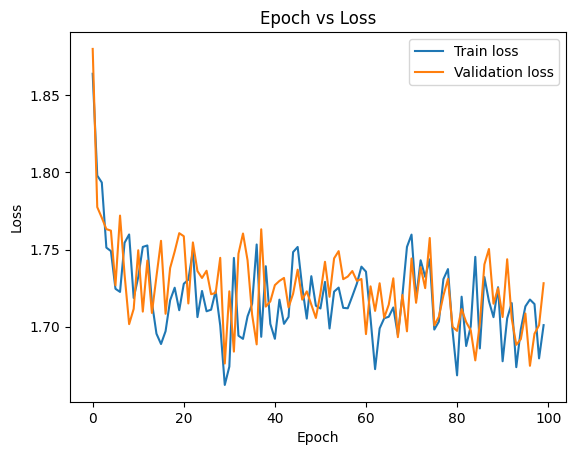

In [ ]:
model = X3ECGpp(num_classes = 12).to(device)
train_model(model, train_dl, validation_dl, epoches=100, learning_rate=7.5e-5)

[INFO] Train accuracy = 0.92812 | f1-score = 0.90279
[INFO] Validation accuracy = 0.915 | f1-score = 0.88993
[INFO] Test accuracy = 0.88989 | f1-score = 0.86009


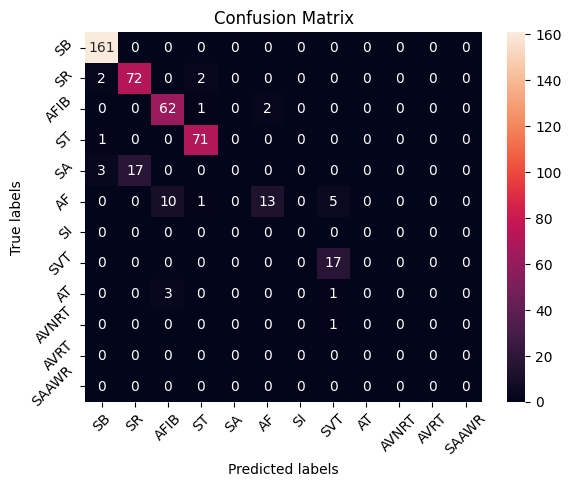

In [ ]:
evaluate_model(model, train_dl, "Train")
evaluate_model(model, validation_dl, "Validation")
evaluate_model(model, test_dl, "Test")

In [ ]:
# torch.save(model, "/content/drive/MyDrive/Intelliscope/Software/ML/Classification 12/model_for_12_classes.pt")